In [31]:
# packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
import datetime as dt
import matplotlib
import statsmodels.api as sm
import scipy.stats as ss

from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

In [17]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
df = pd.read_csv('/content/drive/My Drive/ms_wind_curtailment_prediction/curtailment_target_features.csv', sep = ';', index_col=0)

Graphs to have

1. value counts bar graph to show class imbalance and show why it doesnt make sense to take accuracy as a metric
2. irregularity of redispatch against time
3. feature importance
4. autocorrelation of redispatch against time

Class Imbalance

In [4]:
df.redispatch.value_counts()

0.0    131810
1.0      8398
Name: redispatch, dtype: int64

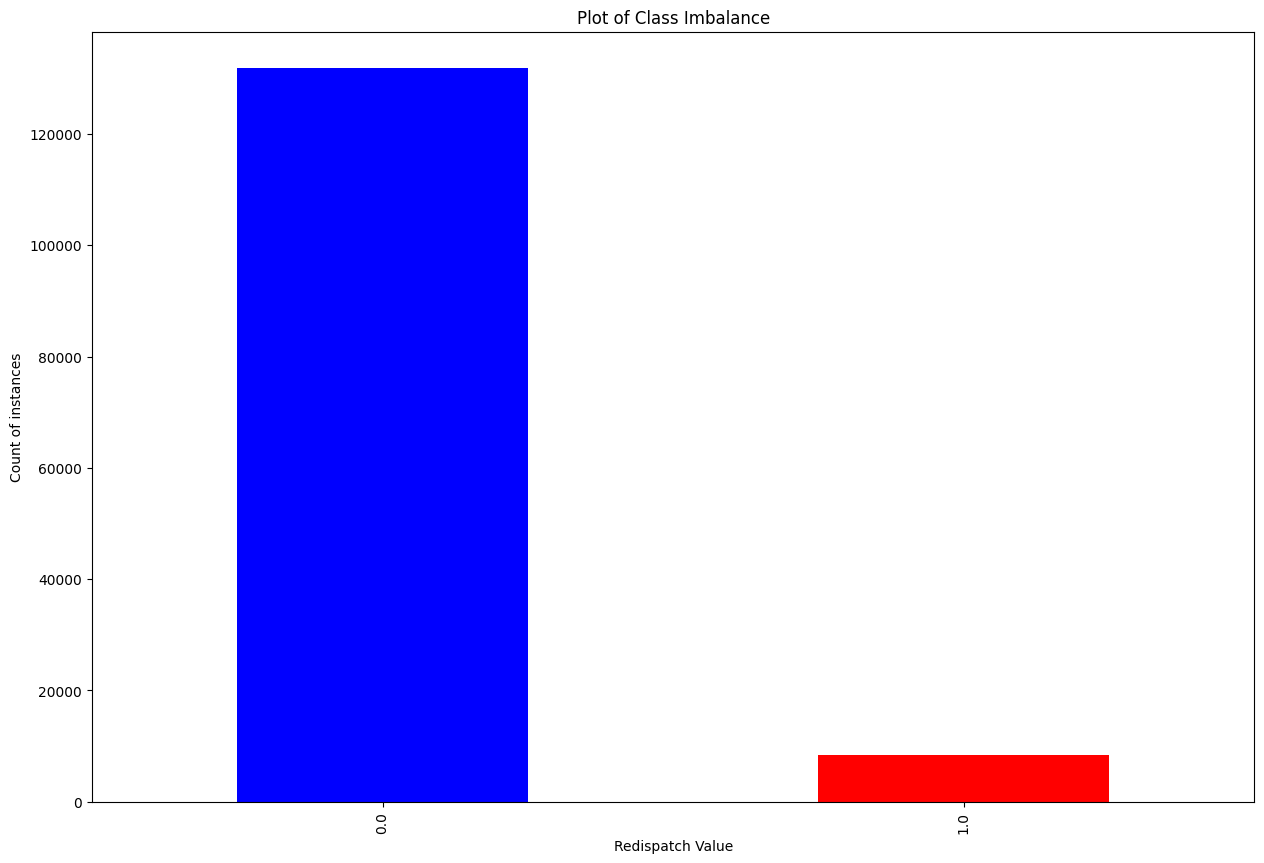

In [5]:
df.redispatch.value_counts().plot(kind='bar', figsize=(15, 10), color=['blue', 'red'])
# Add labels and title
plt.xlabel('Redispatch Value')
plt.ylabel('Count of instances')
plt.title('Plot of Class Imbalance')

plt.savefig('class_imbalance.png')

# Show the plot
plt.show()

Redispatch vs different instances of time

Redispatch for a year

In [ ]:
start_date = '2022-01-01'
end_date = '2023-12-31'

df_week = df.loc[start_date:end_date]

# Plot the column against the datetime index
df_week['redispatch'].plot(figsize=(15, 10))

# Customize the x-axis format
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Redispatch')
plt.title('Plot of Redispatch for a year')

plt.savefig('redispatch_week.png')

# Show the plot
plt.show()

Redispatch for a month

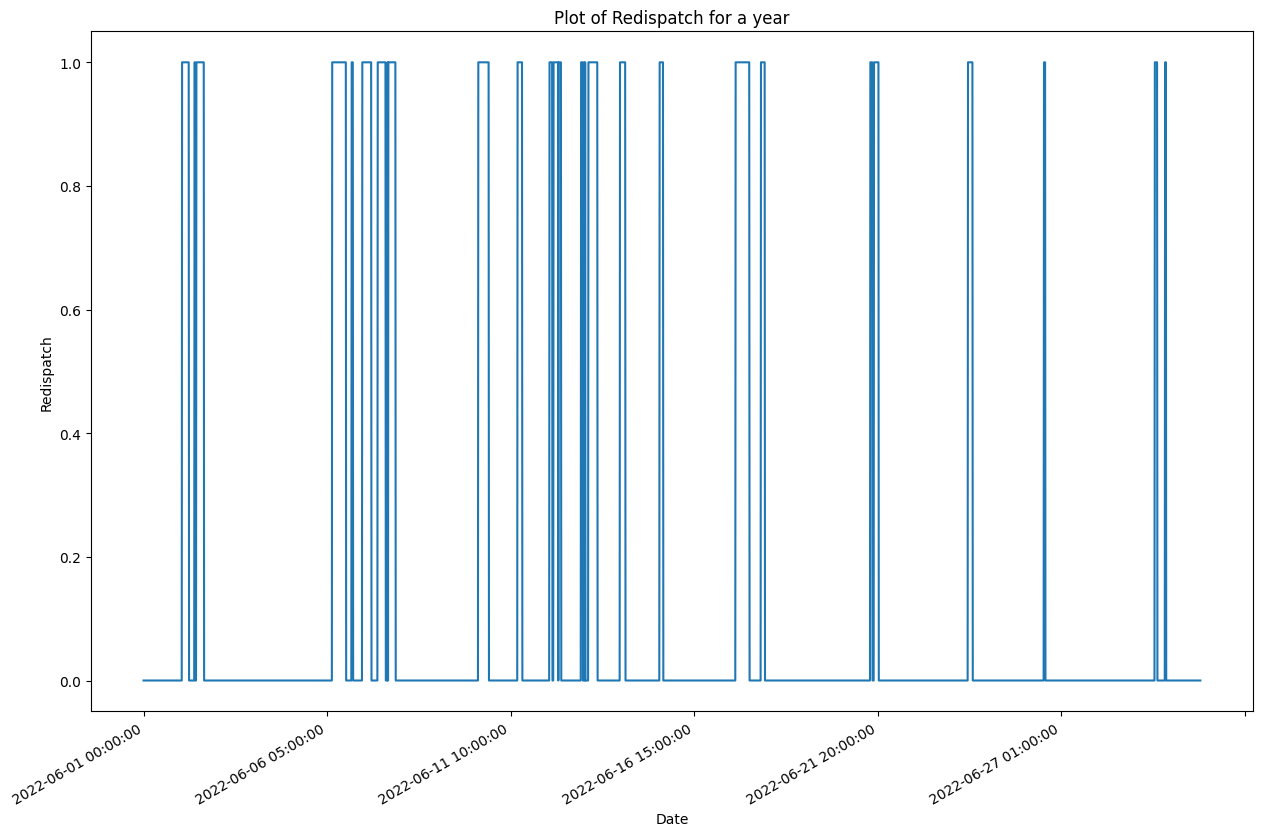

In [7]:
start_date = '2022-06-01'
end_date = '2022-06-31'

df_week = df.loc[start_date:end_date]

# Plot the column against the datetime index
df_week['redispatch'].plot(figsize=(15, 10))

# Customize the x-axis format
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Redispatch')
plt.title('Plot of Redispatch for a year')

plt.savefig('redispatch_week.png')

# Show the plot
plt.show()

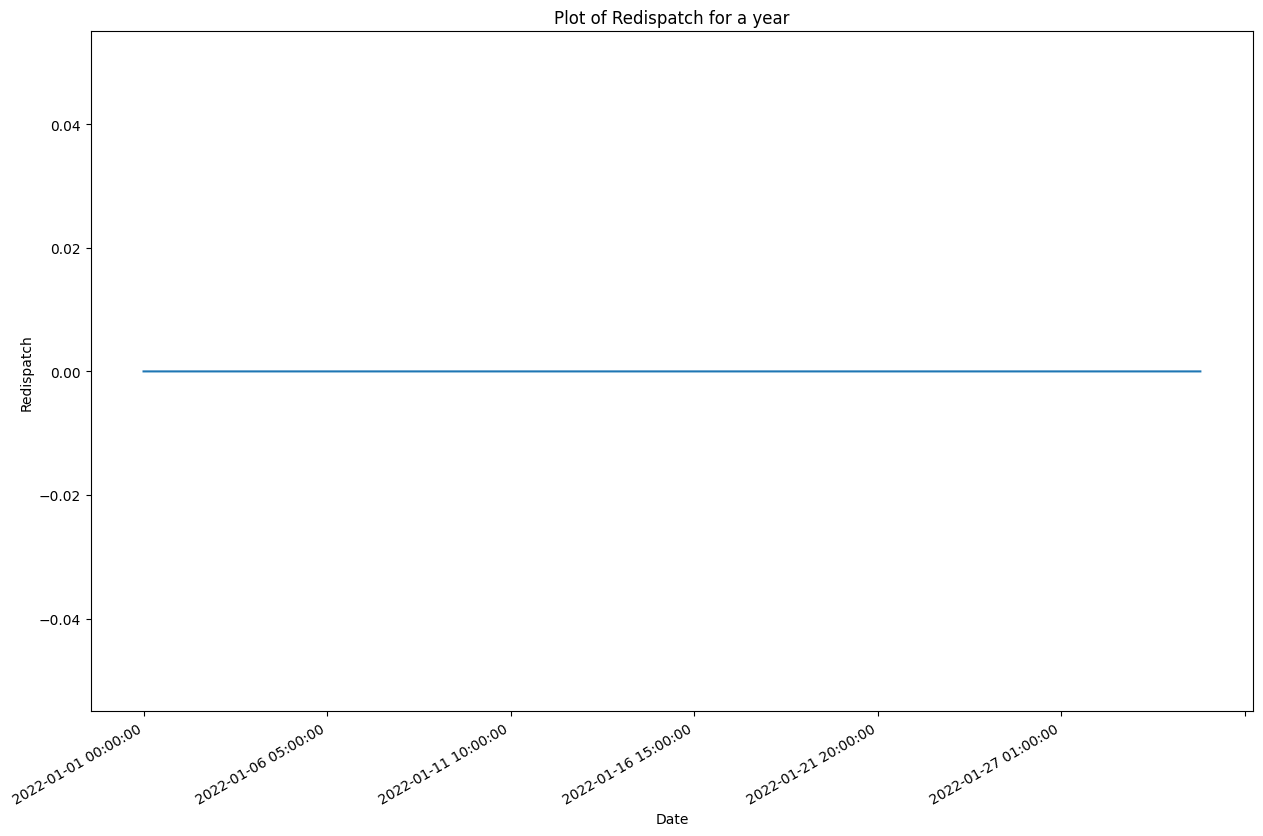

In [8]:
start_date = '2022-01-01'
end_date = '2022-01-31'

df_week = df.loc[start_date:end_date]

# Plot the column against the datetime index
df_week['redispatch'].plot(figsize=(15, 10))

# Customize the x-axis format
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Redispatch')
plt.title('Plot of Redispatch for a year')

plt.savefig('redispatch_week.png')

# Show the plot
plt.show()

Redispatch for

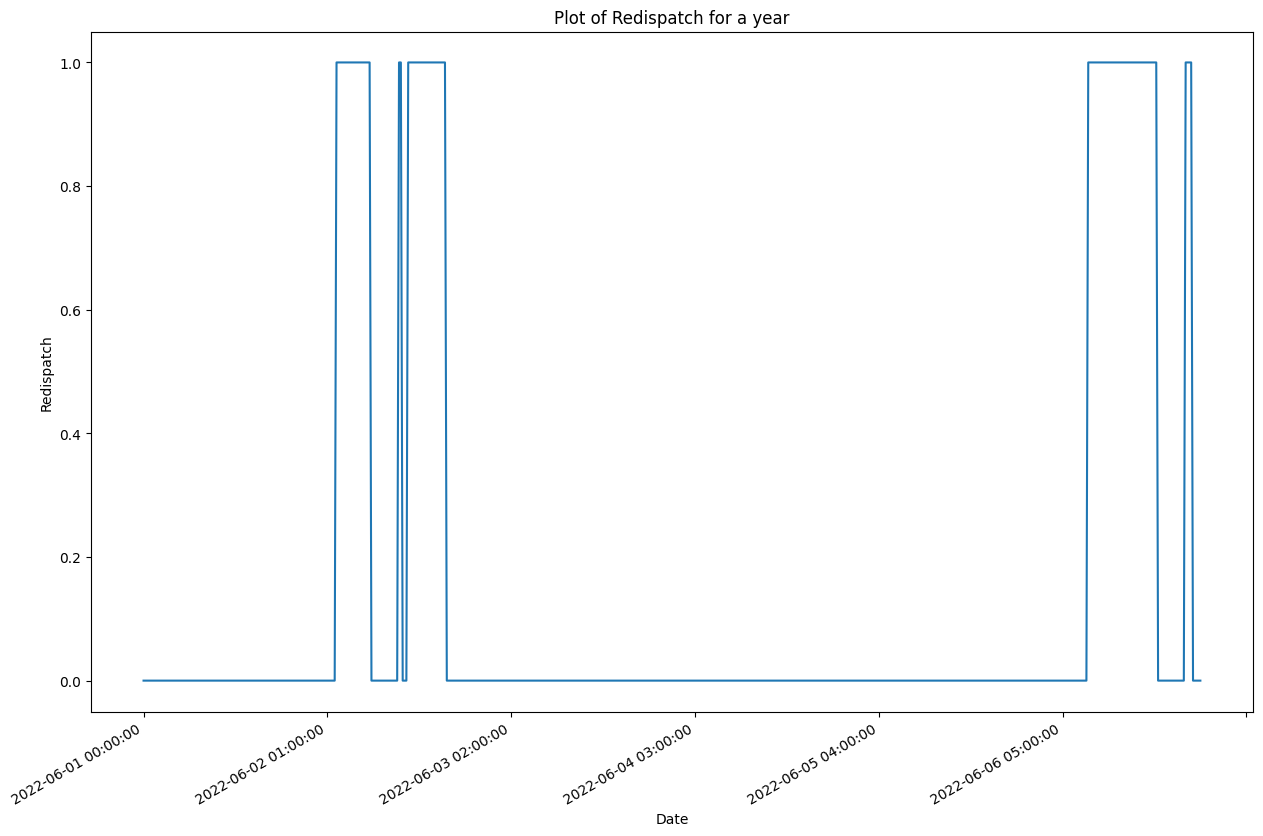

In [10]:
start_date = '2022-06-01'
end_date = '2022-06-07'

df_week = df.loc[start_date:end_date]

# Plot the column against the datetime index
df_week['redispatch'].plot(figsize=(15, 10))

# Customize the x-axis format
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Redispatch')
plt.title('Plot of Redispatch for a year')

plt.savefig('redispatch_week.png')

# Show the plot
plt.show()

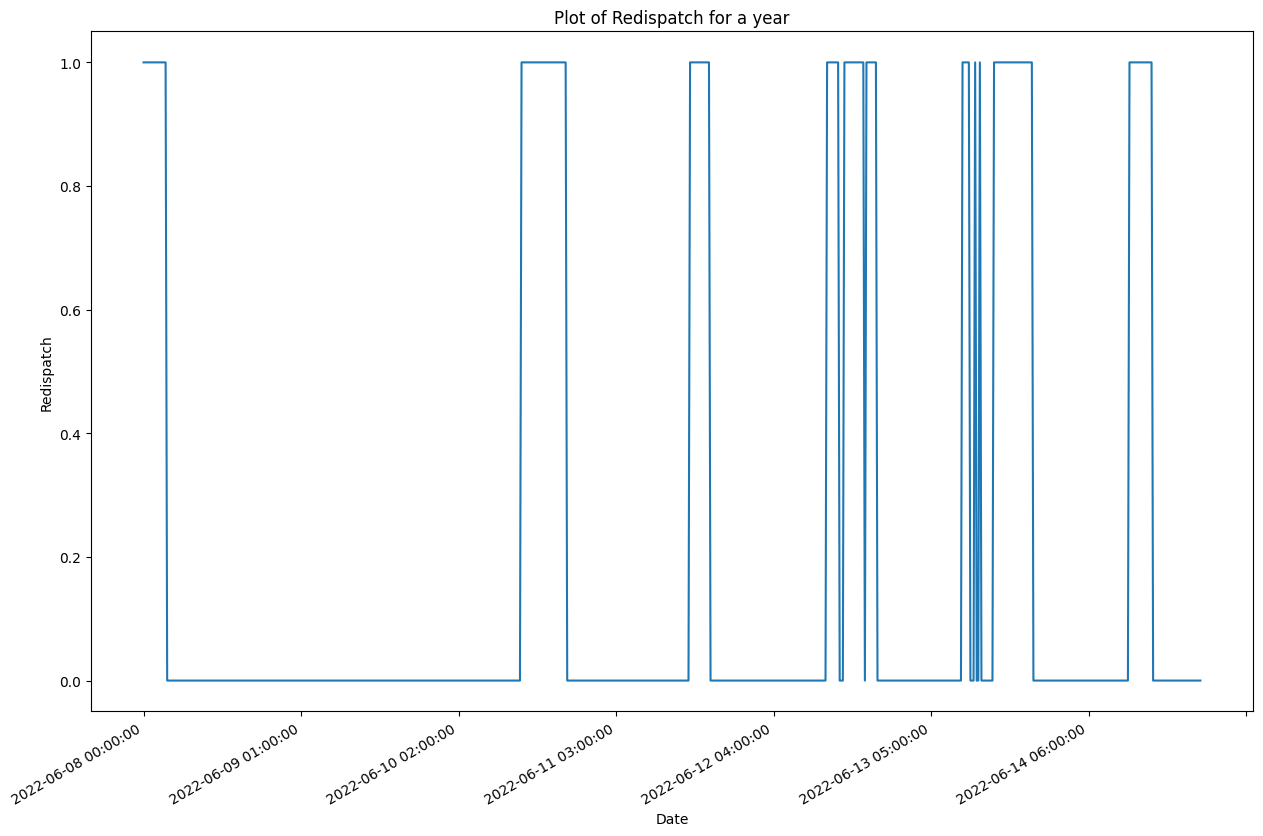

In [12]:
start_date = '2022-06-08'
end_date = '2022-06-15'

df_week = df.loc[start_date:end_date]

# Plot the column against the datetime index
df_week['redispatch'].plot(figsize=(15, 10))

# Customize the x-axis format
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Redispatch')
plt.title('Plot of Redispatch for a year')

plt.savefig('redispatch_week.png')

# Show the plot
plt.show()

Autocorrelation of redispatch

<Figure size 1000x600 with 0 Axes>

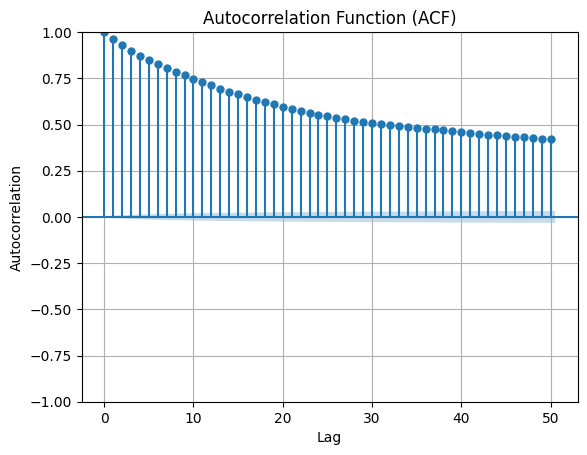

Autocorrelation: 0.960101247666363


In [15]:
# Calculate autocorrelation function (ACF)
acf = pd.Series(data=df['redispatch']).autocorr()

# Plot autocorrelation function (ACF)
plt.figure(figsize=(10, 6))
plot_acf(df['redispatch'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

print("Autocorrelation:", acf)

Imputing all missing values

In [19]:
# Loop through DataFrame rows
for index, row in df.iterrows():
    # Check if column 'forecast_solar_MW' is NaN
    if pd.isna(row['forecast_solar_MW']):
        # If 'forecast_solar_MW' is NaN, fill it with the value from 'actual_solar_MW'
        df.at[index, 'forecast_solar_MW'] = row['actual_solar_MW']

    if pd.isna(row['actual_solar_MW']):
      df.at[index, 'actual_solar_MW'] = row['forecast_solar_MW']


columns_to_interpolate = ["wind_speed_m/s",  "wind_direction_degrees", "humidity_percent", "radiation_global_J/m2", "air_temperature_K", "wind_gust_max_m/s", "wind_direction_gust_max_degrees", "forecast_solar_MW", "actual_solar_MW", "total_grid_load_MWh", "residual_load_MWh", "pumped_storage_MWh"]

# Assuming df is your DataFrame with missing values
df[columns_to_interpolate] = df[columns_to_interpolate].interpolate(method='linear', limit_direction='both')

In [20]:
df.drop('level', inplace=True, axis=1)

In [21]:
df.index = pd.to_datetime(df.index)

Feature importance

1. feature importance through linear models
2. feature importance through tree based models
3. feature importance through permutation
Ensemble Methods: Combining results from multiple feature importance methods or ensembling feature selection techniques can provide a more comprehensive assessment of feature relevance.

In [28]:
X = df.drop('redispatch', axis=1)
y = df['redispatch']

In [37]:
#Feature importance through permutation

# Define your classifier
clf = RandomForestClassifier()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Initialize lists to store feature importances
all_feature_importances = []

# Perform Time Series Cross Validation
for i, (train_index, test_index) in enumerate(tscv.split(X), 1):
    print(f"Processing split {i}/{tscv.n_splits}")
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Balance the classes using SMOTE
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # Fit your classifier to the balanced training data
    clf.fit(X_train_balanced, y_train_balanced)

    # Calculate permutation importance
    perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

    # Get feature importances
    feature_importances = perm_importance.importances_mean

    # Append feature importances to the list
    all_feature_importances.append(feature_importances)

    # Get feature names
    feature_names = X.columns

    # Combine feature names and their importances
    feature_importance_dict = dict(zip(feature_names, feature_importances))

    # Sort features by importance
    sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

    # Print or visualize sorted feature importances
    for feature, importance in sorted_feature_importance:
        print(f"{feature}: {importance}")

# Calculate average feature importance across all folds
avg_feature_importances = np.mean(all_feature_importances, axis=0)

# Get feature names
feature_names = X.columns

# Combine feature names and their importances
feature_importance_dict = dict(zip(feature_names, avg_feature_importances))

# Sort features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print or visualize sorted feature importances
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


Processing split 1/5
wind_direction_degrees: 0.0001754536117767991
air_temperature_K: 0.00012410133515921017
total_grid_load_MWh: 8.55871276959852e-05
wind_direction_gust_max_degrees: 6.84697021568037e-05
pumped_storage_MWh: 5.1352276617577794e-05
humidity_percent: 2.5676138308783347e-05
wind_speed_m/s: 2.5676138308772244e-05
forecast_solar_MW: 2.1396781923987974e-05
actual_solar_MW: 1.2838069154397225e-05
radiation_global_J/m2: 8.558712769590749e-06
residual_load_MWh: 8.558712769590749e-06
wind_gust_max_m/s: 0.0
Processing split 2/5
air_temperature_K: 4.7072920232782424e-05
pumped_storage_MWh: -0.00021824717562484163
total_grid_load_MWh: -0.0004364943512496167
humidity_percent: -0.0006033892502568028
residual_load_MWh: -0.0008344744950359861
wind_direction_gust_max_degrees: -0.0010826771653543953
wind_direction_degrees: -0.001172543649435176
wind_gust_max_m/s: -0.001193940431359186
wind_speed_m/s: -0.001215337213283163
radiation_global_J/m2: -0.0017716535433071057
forecast_solar_MW: -

In [74]:
feature_importance_df = pd.DataFrame.from_dict(feature_importance_dict, orient='index', columns=['Importance'])
# Reset the index to a new column named 'Feature'
feature_importance_df = feature_importance_df.reset_index()

# Rename the columns to match your requirements
feature_importance_df.columns = ['Features', 'Importance']

feature_importance_df

,Features,Importance
0,wind_speed_m/s,0.262666
1,wind_direction_degrees,-0.290085
2,radiation_global_J/m2,-0.154403
3,air_temperature_K,0.109392
4,humidity_percent,0.008342
5,wind_gust_max_m/s,0.073411
6,wind_direction_gust_max_degrees,0.335428
7,forecast_solar_MW,0.977399
8,actual_solar_MW,-0.059727
9,total_grid_load_MWh,0.171309


In [50]:
#feature importance through linear models like logistic regression

# Define your classifier (Logistic Regression)
clf = LogisticRegression()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Initialize lists to store feature importances and their names
feature_importances_list = []
feature_names = X.columns

# Initialize pipeline
pipeline = Pipeline([('scaler', scaler), ('smote', smote), ('clf', clf)])

# Perform Time Series Cross Validation
for i, (train_index, test_index) in enumerate(tscv.split(X), 1):
    print(f"Processing split {i}/{tscv.n_splits}")
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Store the feature importances
    feature_importances_list.append(pipeline.named_steps['clf'].coef_[0])

# Calculate mean feature importances across all splits
mean_feature_importances = np.mean(feature_importances_list, axis=0)

# Combine feature names and their importances
feature_importance_dict = dict(zip(feature_names, mean_feature_importances))

# Sort features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print or visualize sorted feature importances
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Processing split 1/5
Processing split 2/5
Processing split 3/5
Processing split 4/5
Processing split 5/5
forecast_solar_MW: 0.977398763498569
wind_direction_gust_max_degrees: 0.33542750732274285
wind_direction_degrees: -0.2900847188011352
wind_speed_m/s: 0.26266581511788767
total_grid_load_MWh: 0.17130884430970386
radiation_global_J/m2: -0.15440328223569377
air_temperature_K: 0.10939170161154718
wind_gust_max_m/s: 0.0734111285339134
residual_load_MWh: 0.06369026250772755
actual_solar_MW: -0.05972711370575773
humidity_percent: 0.008342446220673311
pumped_storage_MWh: 0.0069984996660245324


Understanding coefficients of logistic regression

Logistic Regression Coefficients: In logistic regression, we're trying to predict a binary outcome (like whether an email is spam or not spam) based on input variables (like email length, number of links, etc.). The coefficients in logistic regression tell us how each input variable contributes to the prediction.

Log Odds: Logistic regression uses a function called the logit function to convert the output into probabilities. So, the coefficients represent the log odds that an observation belongs to one of the classes (like spam or not spam).

Interpreting Coefficients: To interpret these coefficients, we need to convert them from log odds to regular odds. We do this by exponentiating them (using np.exp() in Python).

Example Interpretation: Let's say we're predicting whether a house will sell quickly based on features like the number of rooms and the level of pollution nearby. If the coefficient for the number of rooms is 2.0, it means that for every additional room, the odds of the house selling quickly are 2 times larger than the odds of it not selling quickly, assuming all other factors remain constant.

Negative Coefficients: If a coefficient is negative, it means that as the corresponding feature increases, the odds of the observation belonging to the target class decrease. We can interpret these by taking the reciprocal (1 divided by the odds), which gives us the odds of the observation not belonging to the target class.

In [64]:
# Convert the dictionary to a DataFrame
values_feature_importance = pd.DataFrame.from_dict(feature_importance_dict, orient='index', columns=['Importance'])

# Reset the index to a new column named 'Feature'
values_feature_importance = values_feature_importance.reset_index()

# Rename the columns to match your requirements
values_feature_importance.columns = ['Features', 'Importance']


In [65]:
values_feature_importance['Importance'] = values_feature_importance['Importance'].apply(np.exp)

values_feature_importance = values_feature_importance.sort_values(by='Importance', ascending=False)

values_feature_importance

,Features,Importance
7,forecast_solar_MW,2.657534
6,wind_direction_gust_max_degrees,1.398538
0,wind_speed_m/s,1.300392
9,total_grid_load_MWh,1.186857
3,air_temperature_K,1.115599
5,wind_gust_max_m/s,1.076173
10,residual_load_MWh,1.065762
4,humidity_percent,1.008377
11,pumped_storage_MWh,1.007023
8,actual_solar_MW,0.942022
